In [1]:
# get_ipython().magic('matplotlib notebook')
# get_ipython().magic('matplotlib inline')
# get_ipython().magic('load_ext autoreload')
# get_ipython().magic('autoreload 2')
%matplotlib inline
%load_ext autoreload
%autoreload 2
    
#___________________________________________________________________________________________________________________
import os
import tripyview as tpv
import shapefile as shp
import numpy     as np
import xarray    as xr
import time      as clock

/albedo/home/pscholz/tripyview


### INFO:
To compute the MOC especially on large unstructured grids #vertices>1M you need to run this notebook in parallel on several workers. Therefor uncomment the subsequent cell and allocate a full compute node of a HPC with as much memory as you can get to run this notebook!

In [2]:
# from dask.distributed import Client, LocalCluster
# from dask.diagnostics import ProgressBar
# import dask

# n_workers= 24  #36 #48 #64 #96
# tot_mem  = 256 #100 # GB
# print(' --> memory_limit: {:3.3f} GB'.format(tot_mem/(n_workers+1)))
# client = Client(n_workers=n_workers, threads_per_worker=1, memory_limit='{:3.3f} GB'.format(tot_mem/n_workers))
# client

In [3]:
# Parameters
# mesh_path ='/work/ollie/projects/clidyn/FESOM2/meshes/core2/'
mesh_path = '/albedo/work/user/pscholz/mesh_fesom2.0/core2_srt_dep@node/'
save_path = None #'~/figures/test_papermill/'
save_fname= None

#_____________________________________________________________________________________
which_cycl= None #5 # set None --> take path as in input_paths otherwise add dir of cycle
which_mode= 'z-xmoc'

#_____________________________________________________________________________________
input_paths= list()
# input_paths.append('/albedo/work/projects/p_fesom/pscholz/project_TRR181/trr181_tke+idemix_jayne_bin_ck0.1/5/')
# input_paths.append('/albedo/work/projects/p_fesom/pscholz/project_TRR181/trr181_tke+idemix_nycander_bin_ck0.1/')
# input_paths.append('/albedo/work/projects/p_fesom/pscholz/project_TRR181/trr181_tke+idemix_stormtide_bin_ck0.1/')
input_paths.append('/albedo/work/projects/p_fesom/pscholz/project_TRR181/trr181_tke_ctrl_ck0.1/5/')

input_names= list()
# input_names.append('TKE+IDEMIX, jayne')
# input_names.append('TKE+IDEMIX, nycander')
# input_names.append('TKE+IDEMIX, stormtide')
input_names.append('TKE')

vname     = 'gmoc' # 'gmoc', 'amoc', 'aamoc', 'ipmoc', 'pmoc', 'imoc'
year      = [1979,2019]
# year      = [1950,1950]
mon, day, record, box, depth = None, None, None, None, None

#_____________________________________________________________________________________
# do anomaly plots in case ref_path is not None
ref_path  = None #'/home/ollie/pscholz/results/trr181_tke_ctrl_ck0.1_v2/' # None
ref_name  = None #'TKE, ck=0.1' # None
ref_year  = None #[1979,2019]
ref_mon, ref_day, ref_record = None, None, None
ref_cstr, ref_cnum = 'blue2red', 20
ref_cref, ref_crange, ref_cmin, ref_cmax, ref_cfac, ref_climit = None, None, None, None, None, None
ref_chist, ref_ctresh = True, 0.995
ref_rescale = None

#_____________________________________________________________________________________
cstr      = 'blue2red'
cnum      = 20
cref      = 0
crange, cmin, cmax, cfac, climit = None, None, None, None, None
chist, ctresh = True, 0.995

#_____________________________________________________________________________________
ncolumn   = 2 
do_rescale= None
which_dpi = 300
do_contour= True
do_reffig = True
figfac    = [8, 3.5] #[7, 3.5]
do_wbolus = True
do_1flag  = True

In [4]:
#___LOAD FESOM2 MESH___________________________________________________________________________________
mesh=tpv.load_mesh_fesom2(mesh_path, do_rot='None', focus=0, do_info=True, do_pickle=True)

#______________________________________________________________________________________________________
if (which_cycl is not None) and (which_cycl != "None") and do_1flag: 
    for ii,ipath in enumerate(input_paths):
        input_paths[ii] = os.path.join(ipath,'{:d}/'.format(which_cycl))
        print(ii, input_paths[ii])
        
    if (ref_path is not None) and (ref_path != "None"): 
        ref_path = os.path.join(ref_path,'{:d}/'.format(which_cycl))
        print('R', ref_path)        
    do_1flag=False
    
#______________________________________________________________________________________________________        
cinfo=tpv.set_cinfo(cstr, cnum, crange, cmin, cmax, cref, cfac, climit, chist, ctresh)
ref_cinfo=None
if (ref_path is not None) and (ref_path != "None"): 
    if ref_year   is None: ref_year   = year
    if ref_mon    is None: ref_mon    = mon
    if ref_record is None: ref_record = record    
    cinfo['cref']=0.0 
    ref_cinfo=tpv.set_cinfo(ref_cstr, ref_cnum, ref_crange, ref_cmin, ref_cmax, ref_cref, ref_cfac, ref_climit, ref_chist, ref_ctresh)    
    ref_cinfo['cref']=0.0 
else:
    do_reffig=False  
    
#______________________________________________________________________________________________________    
# concatenate list = list1+list2
if (ref_path is not None) and (ref_path != "None"): 
    if isinstance(ref_path, list): 
        input_paths, input_names = ref_path + input_paths, ref_name + input_names
    else:    
        input_paths, input_names = list([ref_path]) + input_paths, list([ref_name]) + input_names  

#______________________________________________________________________________________________________
# use number of worker dependent chunk size for nodes and elements
try:
    n_workers
    # use number of worker dependent chunking 
    chunks={'time':100, 'nod2':np.ceil(mesh.n2dn/n_workers), 'elem':np.ceil(mesh.n2de/n_workers)}   
except NameError: 
    # use default chunking 
    chunks={'time':100, 'elem':1e4, 'nod2':1e4}

 > found *.pckl file: /albedo/work/user/pscholz/mesh_fesom2.0/core2_srt_dep@node
 > load  *.pckl file: tripyview_fesom2_core2_srt_dep@node_focus0.pckl
___FESOM2 MESH INFO________________________
 > path            = /work/ollie/pscholz/mesh_fesom2.0/core2_srt_dep@node
 > id              = core2_srt_dep@node
 > do rot          = None
 > [al,be,ga]      = 50, 15, -90
 > do augmpbnd     = True
 > do cavity       = False
 > do lsmask       = True
 > do earea,eresol = True, False
 > do narea,nresol = True, False
___________________________________________
 > #node           = 126858
 > #elem           = 244659
 > #lvls           = 48
___________________________________________


/albedo/home/pscholz/tripyview/tripyview/sub_mesh.py:138: UserWarning: Unpickling a shapely <2.0 geometry object. Please save the pickle again; shapely 2.1 will not have this compatibility.
  mesh = pickle.load(fid)


/albedo/work/projects/p_fesom/pscholz/project_TRR181/trr181_tke_ctrl_ck0.1/5/ TKE


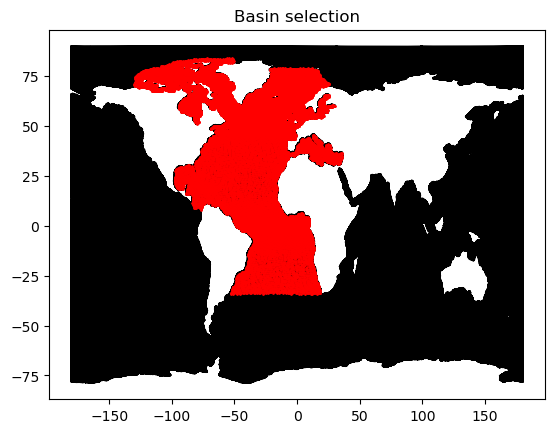

 --> elasped time: 0.09345975716908773 min.


In [5]:
aux_vname, aux_vnamebv = 'w', 'bolus_w'
#______________________________________________________________________________________________________    
ts = clock.time()
flag_checkb = True
zmoc_list = list()
for ii, (datapath, descript) in enumerate(zip(input_paths, input_names)): 
    print(datapath, descript)
    #__________________________________________________________________________________________________
    # load data
    data = tpv.load_data_fesom2(mesh, datapath, vname=aux_vname, year=year, descript=descript, 
                                do_info=False, do_zarithm=None, do_nan=False, chunks=chunks,
                                do_load=False, do_persist=True, )
    
    #__________________________________________________________________________________________________    
    # check if data where loaded
    if data is None: raise ValueError(f'data == None, data could not be readed, your path:{datapath} might be wrong!!!')
    
    #__________________________________________________________________________________________________    
    if do_wbolus: data[aux_vname].data = data[aux_vname].data+tpv.load_data_fesom2(mesh, datapath, vname=aux_vnamebv, year=year, 
                                        do_info=False, do_zarithm=None, do_nan=False, chunks=chunks,
                                        do_load=False, do_persist=True, )[aux_vnamebv].data
        
    #__________________________________________________________________________________________________        
    # compute zmoc    
    zmoc     = tpv.calc_zmoc(mesh, data, dlat=1.0, which_moc=vname, do_info=False, do_checkbasin=flag_checkb,
                             chunks=chunks, do_onelem=False, do_load=True)
    flag_checkb = False
    del(data)
    
    #__________________________________________________________________________________________________        
    # compute absolute or anomalie    
    if (ref_path is not None) and (ref_path != "None"): 
        if ii == 0: 
            zmoc_ref = zmoc.copy()
            if do_reffig: zmoc_list.append(zmoc_ref) 
        else:        
            zmoc_list.append( tpv.do_anomaly(zmoc, zmoc_ref) )
    else:                                                   
        zmoc_list.append( zmoc )
    del(zmoc)        
if (ref_path is not None) and (ref_path != "None"): del(zmoc_ref)    
print(' --> elasped time: {} min.'.format( (clock.time()-ts)/60  ))

--> histo: cmin, cmax =  -2.1504769609649084 15.003836151129121
{'cstr': 'blue2red', 'cnum': 20, 'cref': 0, 'chist': True, 'ctresh': 0.995, 'cmin': -2.1505, 'cmax': 15.0038, 'cmap': <matplotlib.colors.ListedColormap object at 0x15409cdc3eb0>, 'clevel': array([-2.5, -2. , -1.5, -1. , -0.5,  0. ,  0.5,  1. ,  1.5,  2. ,  2.5,
        3. ,  3.5,  4. ,  4.5,  5. ,  5.5,  6. ,  6.5,  7. ,  7.5,  8. ,
        8.5,  9. ,  9.5, 10. , 10.5, 11. , 11.5, 12. , 12.5, 13. , 13.5,
       14. , 14.5, 15. , 15.5])}


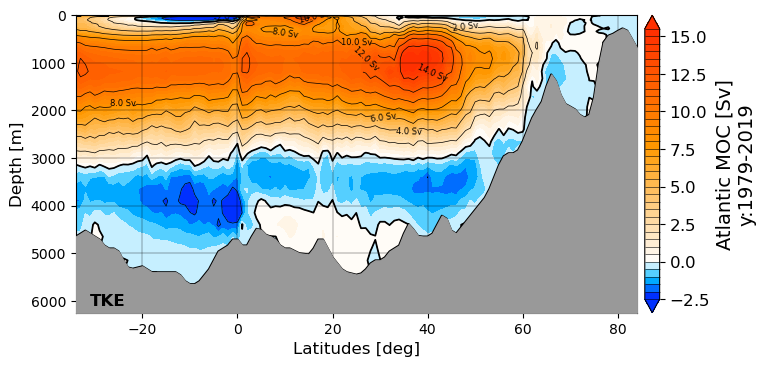

In [6]:
#___PLOT FESOM2 DATA___________________________________________________________________________________
spath  = save_path
sname  = vname
slabel = zmoc_list[0]['zmoc'].attrs['str_lsave']
if spath is not None: spath  = os.path.join(spath,'{}_{}_{}.png'.format(which_mode, sname, slabel)) 
ncolumn= np.min([ncolumn,len(zmoc_list)])        
nrow   = np.ceil(len(zmoc_list)/ncolumn).astype('int')
if save_fname is not None: spath = save_fname
pos_gap = [0.01, 0.04]

#____________________________________________________________________________________________________
fig, ax, cbar=tpv.plot_zmoc(zmoc_list, which_moc=vname, cinfo=cinfo, figsize=[ncolumn*figfac[0], nrow*figfac[1]], 
                            n_rc=[nrow, ncolumn], pos_gap=pos_gap, pos_extend=[0.05, 0.05, 0.85, 0.90], 
                            do_reffig=do_reffig, ref_cinfo=ref_cinfo, 
                            do_save=spath, save_dpi=which_dpi, do_contour=do_contour)